In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# Download YOLO files (if not already downloaded)
!mkdir -p /content/yolo-coco
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O /content/yolo-coco/coco.names
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O /content/yolo-coco/yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3.weights -O /content/yolo-coco/yolov3.weights

--2024-11-27 06:45:50--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘/content/yolo-coco/coco.names’

/content/yolo-coco/ 100%[===================>]     625  --.-KB/s    in 0s      

2024-11-27 06:45:51 (26.2 MB/s) - ‘/content/yolo-coco/coco.names’ saved [625/625]

--2024-11-27 06:45:51--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/

In [12]:
# Simulate argparse arguments
import sys
sys.argv = ['yolo_colab.py', '--image', '/content/cat1.jpg', '--confidence', '0.5', '--threshold', '0.3']

# Import argparse and parse the arguments
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="path to input image")
ap.add_argument("-c", "--confidence", type=float, default=0.5, help="minimum probability to filter weak detections")
ap.add_argument("-t", "--threshold", type=float, default=0.3, help="threshold when applying non-maxima suppression")
args = vars(ap.parse_args())

In [14]:
# Load YOLO model
labelsPath = '/content/yolo-coco/coco.names'
LABELS = open(labelsPath).read().strip().split("\n")

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

weightsPath = '/content/yolo-coco/yolov3.weights'
configPath = '/content/yolo-coco/yolov3.cfg'

# Load the YOLO network
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [15]:
# Read input image
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

# Get output layer names
ln = net.getLayerNames()
output_layers = net.getUnconnectedOutLayers()

# Adjust for 1-based index in OpenCV (subtract 1)
ln = [ln[i - 1] for i in output_layers.flatten()]

# Prepare the image for detection
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 3.052399 seconds


In [16]:
# Initialize lists for detected bounding boxes, confidences, and class IDs
boxes = []
confidences = []
classIDs = []

# Process each layer's output
for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > args["confidence"]:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

# Apply non-maxima suppression
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])

In [17]:
# Ensure at least one detection exists
if len(idxs) > 0:
    for i in idxs.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Convert BGR image to RGB for Matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

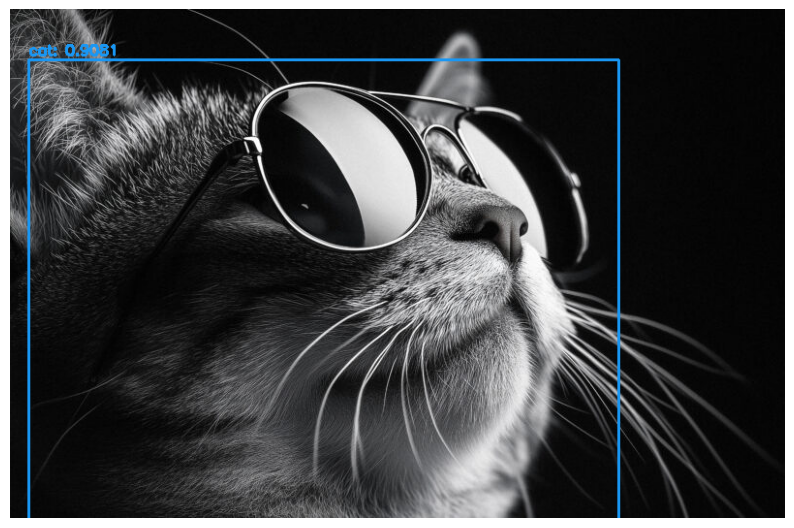

In [18]:
# Display the output image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()